In [43]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial
import datetime

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
import optax
from jax.experimental import optimizers

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import models
import flows

from jax.experimental import optimizers

key, subkey = random.split(random.PRNGKey(0))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
%autoreload

In [44]:
n_steps = 200
n_particles = 50 # per group
svgd_hparams = {
    "target": "squiggle mix".split(),
    "particle_lr": [5e-3, 1e-2, 5e-2],
#     "noise_level": [1e-1, 1.],
    "noise_level": [0.],
    "particle_optimizer": ["sgd"],
}
hparam_product = list(utils.dict_cartesian_product(**svgd_hparams))

In [45]:
# Structure:
# 1) call flow(target, hparams, etc)
# 2) compute final metrics on particles
# 3) save rundata to file

In [46]:
def run(hparams, key):
    "Note: we're always using same random seed."
    data = {"hparams": hparams}
    hparams_run = hparams.copy()
    t = time.time()
    startdate = time.strftime("%Y-%m-%d", time.localtime(t))
    starttime = time.strftime("%H:%M:%S", time.localtime(t))
    filename = f"/home/lauro/code/msc-thesis/svgd/runs/svgd/{startdate}_{starttime}.json" # EDIT HERE
    setup = utils.setup_mapping[hparams_run["target"]]
    del hparams_run["target"]
    target, _ = setup.get()

    # 1) call flow
#     gradient, particles, err =        flows.sgld_flow( key, setup, n_particles=n_particles, n_steps=n_steps, noise_level=noise_level, **hparams)
    gradient, particles, err =        flows.svgd_flow( key, setup, n_particles=n_particles, n_steps=n_steps, scaled=True, **hparams_run)
#     gradient, particles, err =        flows.score_flow(key, setup, n_particles=n_particles, n_steps=n_steps, noise_level=noise_level, scale=1.)

#     gradient, particles, err = flows.neural_svgd_flow( key, setup, n_particles=n_particles, n_steps=n_steps, noise_level=noise_level, learner_lr=1e-3, patience=10)
#     gradient, particles, err = flows.neural_score_flow(key, setup, n_particles=n_particles, n_steps=n_steps, learner_lr=1e-2, patience=5, **hparams_run)
#     gradient, particles, err = flows.deep_kernel_flow( key, setup, n_particles=n_particles, n_steps=n_steps, noise_level=noise_level, learner_lr=1e-3, patience=3)

    # 2) compute final metrics on particles
    final_particles = particles.rundata['particles'][-1][particles.group_idx[0]]
    metrics_dict = metrics.compute_final_metrics(final_particles, target)

    # 3) save rundata
    data.update({
        "particle_data": particles.rundata,
        "gradient_data": gradient.rundata,
        "final_metrics": metrics_dict,
    })
    data = utils.dict_dejaxify(data)

    if os.path.exists(filename):
        filename = filename[:-5] + datetime.datetime.now().strftime(".%f.json")
    with open(filename, "w") as f:
        json.dump(data, f, ensure_ascii=False, indent=4, sort_keys=True, allow_nan=True)
    return gradient, particles, err

In [47]:
key = random.PRNGKey(0)
for subkey in random.split(key, 4):
    for hparams in tqdm(hparam_product):
        gradient, particles, err = run(hparams, subkey)
        if err is not None:
            raise err from None

100%|██████████| 6/6 [00:20<00:00,  3.34s/it]


# get data

In [48]:
import pandas as pd

In [49]:
directory1 = "/home/lauro/code/msc-thesis/svgd/runs/svgd/"
directory2 = "/home/lauro/code/msc-thesis/svgd/runs/neural_score/"

In [73]:
metrics_kernel = []
hparams_kernel = []
final_particles_kernel = []
for filename in os.listdir(directory1):
    data = json.load(directory1 + filename)
    metrics_kernel.append(data["final_metrics"])
    hparams_kernel.append(data["hparams"])
    final_particles_kernel.append(data["particle_data"]["particles"][-1])
metrics_df = pd.DataFrame(metrics_kernel)

In [74]:
metrics_neur = []
hparams_neur = []
final_particles_neur = []
for filename in os.listdir(directory2):
    data = json.load(directory2 + filename)
    metrics_neur.append(data["final_metrics"])
    hparams_neur.append(data["hparams"])
    final_particles_neur.append(data["particle_data"]["particles"][-1])
metrics_neur_df = pd.DataFrame(metrics_neur)

In [68]:
hparams_kernel_df = pd.DataFrame(hparams_kernel)
hparams_neur_df = pd.DataFrame(hparams_neur)
all_kernel_df = pd.concat([metrics_df, hparams_kernel_df],      join="inner", axis=1)
all_neur_df   = pd.concat([metrics_neur_df, hparams_kernel_df], join="inner", axis=1)

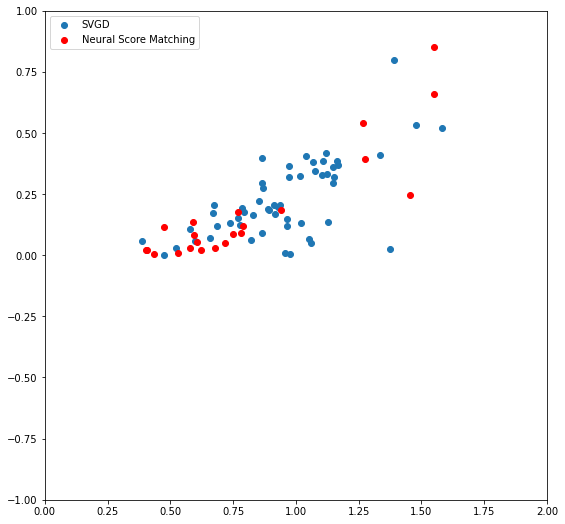

In [52]:
fig, ax = plt.subplots(figsize=[9,9])
plt.scatter(metrics_df.emd, metrics_df.se_mean, label="SVGD")
plt.scatter(metrics_neur_df.emd, metrics_neur_df.se_mean, label="Neural Score Matching", color="red")
ax.set(ylim=(-1, 1), xlim=(0, 2))
plt.legend()

In [70]:
metrics_df.idxmin().emd

0.38554102182388306

In [72]:
all_kernel_df.iloc[43]

emd                    0.385541
ksd                    -1.86061
se_mean               0.0568039
se_var                0.0036832
noise_level                   0
particle_lr                0.05
particle_optimizer          sgd
target                      mix
Name: 43, dtype: object

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)


[(-2.0, 2.0), (-2.0, 2.0)]

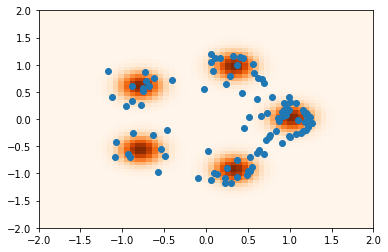

In [86]:
mix, _ = distributions.mix_of_gauss.get()
plot.plot_fun_2d(mix.pdf)
plot.scatter(onp.array(final_particles_kernel[43]))
lim=(-2,2)
plt.gca().set(ylim=lim, xlim=lim)

In [90]:
metrics.compute_final_metrics(final_particles_kernel[43], mix)

{'emd': DeviceArray(0.4298803, dtype=float32),
 'ksd': DeviceArray(-1.0324647, dtype=float32),
 'se_mean': DeviceArray(0.0556741, dtype=float32),
 'se_var': DeviceArray(0.00304107, dtype=float32)}

In [67]:
metrics_neur_df.idxmin().emd

24

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)


[(-2.0, 2.0), (-2.0, 2.0)]

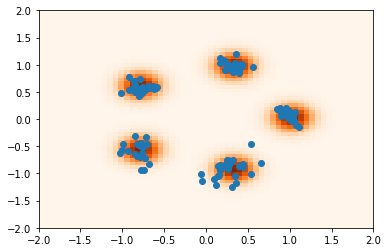

In [87]:
mix, _ = distributions.mix_of_gauss.get()
plot.plot_fun_2d(mix.pdf)
plot.scatter(onp.array(final_particles_neur[24]))
lim=(-2,2)
plt.gca().set(ylim=lim, xlim=lim)

# other

In [38]:
all_df.columns

Index(['emd', 'ksd', 'se_mean', 'se_var', 'noise_level', 'particle_lr',
       'particle_optimizer', 'target'],
      dtype='object')

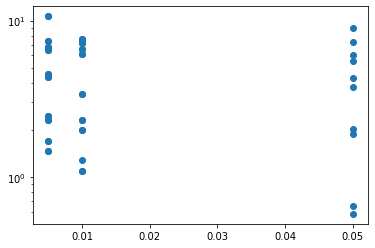

In [48]:
plt.scatter(all_df.particle_lr, all_df.emd)
plt.yscale("log")

<AxesSubplot:xlabel='noise_level', ylabel='emd'>

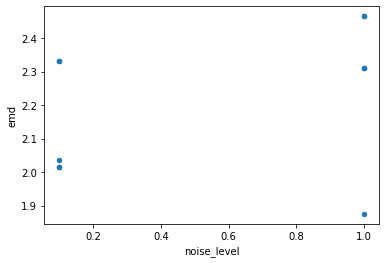

In [46]:
all_df[all_df.target=="squiggle"].plot.scatter(x="noise_level", y="emd")

## sorted comparison

In [12]:
metrics_sorted = sorted(metrics, key=lambda m: m["emd"])

In [15]:
emds = [m["emd"] for m in metrics_sorted]
ksds = [m["ksd"] for m in metrics_sorted]
se_vars = [m["se_var"] for m in metrics_sorted]
se_means = [m["se_mean"] for m in metrics_sorted]

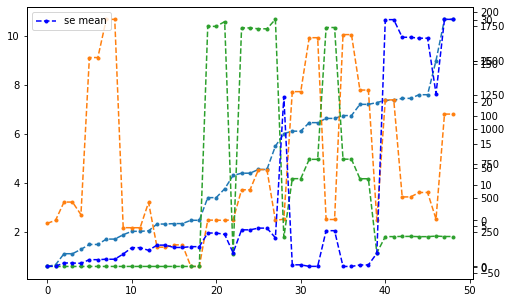

In [22]:
fig, ax = plt.subplots(figsize = [8, 5])
ax.plot(emds, "--.")
ax2 = ax.twinx()
ax2.plot(ksds, "--.", color="tab:orange")
ax3 = ax.twinx()
ax3.plot(se_vars, "--.", color="tab:green")
ax4 = ax.twinx()
ax4.plot(se_means, "--.", color="blue", label="se mean")
plt.legend()